In [10]:
"""
实现esim算法。
使用天池的数据集来测试esim算法的实际效果。
使用10000行数据50轮迭代，差不多能达到80%的准确率。
"""

from torch import nn
import torch
import torch.nn.functional as F
# from toolz.itertoolz.core import partition
import sys
sys.path.append("../common/")
import chinese_preprocess
import sentence_sim_helper
import model_utils
import sequence_utils
import type_cast_helper
from IPython.display import Image

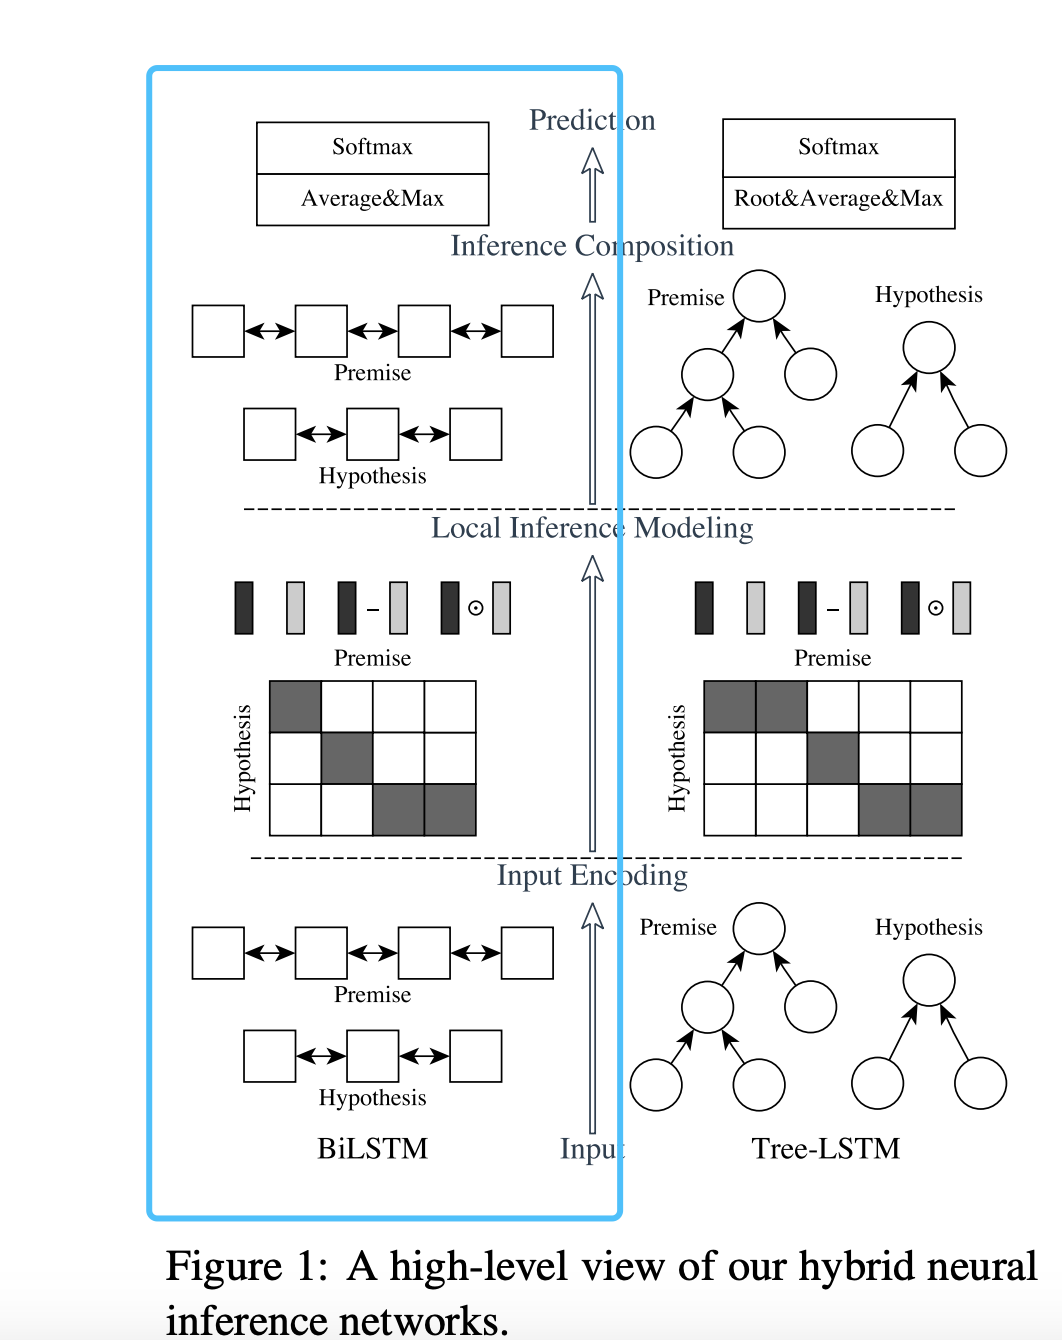

In [11]:
Image(filename='images/esim_high_level.png', width=500)

In [12]:
class ESIM(nn.Module):
    def __init__(self, args):
        super(ESIM, self).__init__()
        self.dropout = 0.5
        self.hidden_size = args["hidden_size"]
        self.embeds_dim = args["embeds_dim"]
        # num_word = 20000
        self.num_word = args["num_word"]
        self.linear_size = args["linear_size"]
        self.embeds = nn.Embedding(self.num_word, self.embeds_dim)
        self.bn_embeds = nn.BatchNorm1d(self.embeds_dim)
        # batch_first: 输入数据的size为[batch_size, time_step, input_size]还是[time_step, batch_size, input_size]
        self.bilstm1 = nn.LSTM(self.embeds_dim, self.hidden_size, batch_first=True, bidirectional=True)
        self.bilstm2 = nn.LSTM(self.hidden_size*8, self.hidden_size, batch_first=True, bidirectional=True)

        self.fc = nn.Sequential(
            nn.BatchNorm1d(self.hidden_size * 8),
            nn.Linear(self.hidden_size * 8, self.linear_size),
            nn.ELU(inplace=True),
            nn.BatchNorm1d(self.linear_size),
            nn.Dropout(self.dropout),
            nn.Linear(self.linear_size, self.linear_size),
            nn.ELU(inplace=True),
            nn.BatchNorm1d(self.linear_size),
            nn.Dropout(self.dropout),
            nn.Linear(self.linear_size, 2),
            nn.Softmax(dim=-1)
        )

    def forward(self, input1, input2):
        # 1. input encoding.
        sent1, sent2 = input1, input2
        mask1, mask2 = sent1.eq(0), sent2.eq(0)
        # 与论文不一样的是加入了BatchNorm1d这一层？- 对比了一下不加，没有太大的差别。
        # x1 = self.embeds(sent1)
        # x2 = self.embeds(sent2)
        # embeds: batch_size * seq_len => batch_size * seq_len * dim
        x1 = self.bn_embeds(self.embeds(sent1).transpose(1, 2).contiguous()).transpose(1, 2)
        x2 = self.bn_embeds(self.embeds(sent2).transpose(1, 2).contiguous()).transpose(1, 2)
        # LSTM输出 output, (h_n, c_n), (h_n, c_n)丢弃了
        # output (seq_len, batch, hidden_size * num_directions): 保存RNN最后一层的输出的Tensor
        o1, _ = self.bilstm1(x1)
        o2, _ = self.bilstm1(x2)

        # 2. local inference. attention计算
        q1_align, q2_align = soft_attention_align(o1, o2, mask1, mask2)
        # inference增强，这里就是按照公式来的。
        # batch_size * seq_len * (8 * hidden_size)
        q1_combined = torch.cat([o1, q1_align, submul(o1, q1_align)], -1)
        q2_combined = torch.cat([o2, q2_align, submul(o2, q2_align)], -1)

        # 3. inference composition。再一次用 BiLSTM 提前上下文信息。
        # batch_size * seq_len * (2 * hidden_size)
        q1_compose, _ = self.bilstm2(q1_combined)
        q2_compose, _ = self.bilstm2(q2_combined)

        # 使用 MaxPooling 和 AvgPooling 进行池化操作。
        # input: batch_size * seq_len * (2 * hidden_size)
        # output: batch_size * (4 * hidden_size)
        q1_rep = apply_multiple(q1_compose)
        q2_rep = apply_multiple(q2_compose)
        # 最后接一个全连接层，输出语义相似度
        x = torch.cat([q1_rep, q2_rep], -1)
        similarity = self.fc(x)
        return similarity

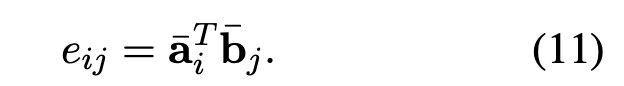

In [13]:
Image(filename='images/esim_atten_calculation.png', width=500)

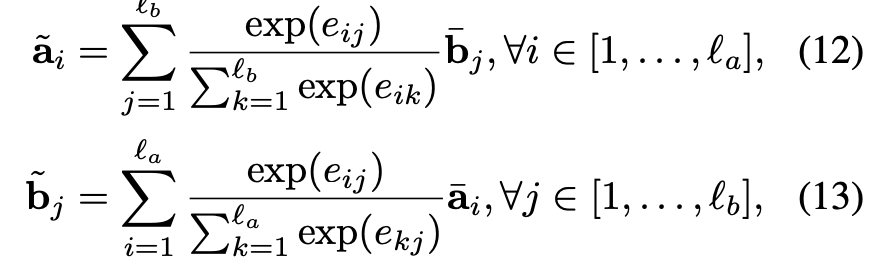

In [14]:
Image(filename='images/esim_atten_calculation2.png', width=500)

In [15]:
def soft_attention_align(x1, x2, mask1, mask2):
    '''
    1. 首先计算两个句子word之间的相似度，得到2维的相似度矩阵，这里会用到 torch.matmul。
    2. 用之前得到的相似度矩阵，结合 a，b 两句话，互相生成彼此相似性加权后的句子，维度保持不变。
    即使a_tlide用b的所有的组合加权表示。
    x1: batch_size * seq_len * dim
    x2: batch_size * seq_len * dim
    '''
    # attention: batch_size * seq_len * seq_len
    # 假设(32, 20, 20)，则attention[0][0][0]存的是e00，attention[0][0][1]存的是e01。即第一个sample对中a的第
    # 一个单词与b的第一个单词的对齐分数e00，和第一个sample对中a的第一个单词与b的第二个单词的对齐分数e01
    attention = torch.matmul(x1, x2.transpose(1, 2))
    # mask变为 [0, 0, -inf] 
    mask1 = mask1.float().masked_fill_(mask1, float('-inf'))
    mask2 = mask2.float().masked_fill_(mask2, float('-inf'))
    """
    attention + mask2.unsqueeze(1)这两个维度不一样还能相加啊？ - 可以的
    attention -  batch_size * seq_len * seq_len
    mask2.unsqueeze(1) - batch_size * 1 * seq_len
    相当于每个attention都与这个mask相加。
    这里attention + mask2.unsqueeze(1)以后，举例说明
    第一个sample对中a的第一个单词与b的后来添加0对齐的单词的weight1的位置都变成了0(因为-inf再softmax)
    """
    # weight: batch_size * seq_len * seq_len
    weight1 = F.softmax(attention + mask2.unsqueeze(1), dim=-1)
    # x_align: batch_size * seq_len * hidden_size
    # x2就是上述的bj
    x1_align = torch.matmul(weight1, x2)
    # 与weight1类似. x1就是上述的ai
    weight2 = F.softmax(attention.transpose(1, 2) + mask1.unsqueeze(1), dim=-1)
    x2_align = torch.matmul(weight2, x1)
    return x1_align, x2_align

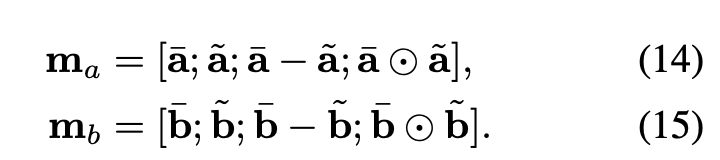

In [16]:
Image(filename='images/esim_feature_combine.png', width=500)

In [17]:
def submul(x1, x2):
    # 按照公式来的
    mul = x1 * x2
    sub = x1 - x2
    return torch.cat([sub, mul], -1)

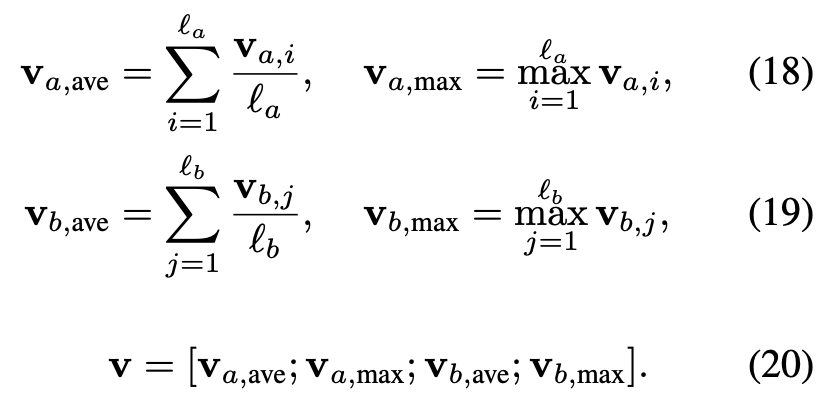

In [18]:
Image(filename='images/esim_pool.png', width=500)

In [19]:
def apply_multiple(x):
    """
    使用 MaxPooling 和 AvgPooling 进行池化操作。只是一种把变长形式变成定长形式的常见
    方法之一。
    :param x:
    :return:
    """
    # input: batch_size * seq_len * (2 * hidden_size)
    p1 = F.avg_pool1d(x.transpose(1, 2), x.size(1)).squeeze(-1)
    p2 = F.max_pool1d(x.transpose(1, 2), x.size(1)).squeeze(-1)
    # output: batch_size * (4 * hidden_size)
    return torch.cat([p1, p2], 1)

In [ ]:
# 使用天池的atec_nlp_sim数据来测试这个model
print("#0 load sim sentence data")
tok, vocab_size, X_train_sen1_encode_int, X_train_sen2_encode_int, X_test_sen1_encode_int, X_test_sen2_encode_int, \
Y_train, Y_test = sentence_sim_helper.prepare_word_encoding_int_for_sentence_sim(1000)

print("#1 create ESIM")
lr = 0.002
args = {
    # bilstm hidden size
    "hidden_size": 128,
    # word embedding size
    "embeds_dim": 128,
    "num_word": vocab_size,
    "linear_size": 64
}
esim_model = ESIM(args)
model_utils.model_parameters_number(esim_model)

print("#2 create optimizer and loss")
optimizer = torch.optim.SGD(esim_model.parameters(), lr=lr)
loss_func = torch.nn.CrossEntropyLoss()

print("#3 start to train")
n_epoch = 50
batch_size = 32
index = 0

# generator转list
sen1_chunks = list(sequence_utils.partition_by_size(X_train_sen1_encode_int, batch_size))
sen2_chunks = list(sequence_utils.partition_by_size(X_train_sen2_encode_int, batch_size))
Y_train_chunks = list(sequence_utils.partition_by_size(Y_train, batch_size))
batch_len = len(sen1_chunks)

for i in range(n_epoch):
    total_loss = 0
    total_count = 0
    total_correct_count = 0
    for (input1, input2, Y_train_batch) in zip(sen1_chunks, sen2_chunks, Y_train_chunks):
        total_count += batch_size
        input1_tensor = type_cast_helper.list_to_tensor(input1).long()
        input2_tensor = type_cast_helper.list_to_tensor(input2).long()
        Y_train_batch_tensor = type_cast_helper.list_to_tensor(Y_train_batch).long()
        output = esim_model(input1_tensor, input2_tensor)
        # index += 1
        loss = loss_func(output, Y_train_batch_tensor)
        total_loss += loss
        value, idx = output.topk(1)
        idx = torch.squeeze(idx, 1)
        correct_count_boolean = idx.eq(Y_train_batch_tensor)
        # 可以直接算True的数目
        correct_count = correct_count_boolean.sum().item()
        total_correct_count += correct_count
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print("epoch %d, average loss %f, accuracy %f" % (i, total_loss / batch_len, total_correct_count / total_count))
print("train finish")
